In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import os
os.environ["TERRA_CONFIG_PATH"] = "/home/sabri/code/spr-21/terra_config.json"

import terra 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
from tqdm.auto import tqdm
from mosaic import DataPanel, NumpyArrayColumn

In [2]:
# Load Celeb DataPanel
from spr.data.celeb import build_celeb_df, get_celeb_dp
celeb_df = build_celeb_df.out(141, load=True)
celeb_dp = get_celeb_dp(celeb_df[celeb_df["split"] == "valid"])

In [3]:
model_df = terra.out(290, load=True)
for idx, (_, row) in tqdm(enumerate(model_df.iterrows())):
    row = row.to_dict()
    act_target = row["target_column"]
    dp = terra.get_artifacts(
        run_id=327, group_name=f"{act_target}_activations"
    )["dp"].load()

    assert celeb_dp["file"] == dp["file"]
    celeb_dp.add_column(f"pred_{act_target}", dp["pred"], overwrite=True)
    celeb_dp.add_column(f"prob_{act_target}", dp["probs"], overwrite=True)

In [37]:
from spr.data.celeb import ATTRIBUTES
from sklearn.metrics import roc_auc_score
from spr.utils import auroc_bootstrap_ci
 
results = []
for target_attr in tqdm(ATTRIBUTES):  
    base_score = roc_auc_score(celeb_dp[target_attr], celeb_dp[f"prob_{target_attr}"].data[:, -1])

    for slice_attr in ATTRIBUTES:
        if target_attr == slice_attr:
            continue
        for slice_value in [0,1]:
            curr_dp = celeb_dp[[f"prob_{target_attr}", slice_attr, target_attr]]
            curr_dp = curr_dp.lz[np.where(curr_dp[slice_attr] == slice_value)[0]]
            if len(np.unique(curr_dp[target_attr])) != 2:
                continue
            ci = auroc_bootstrap_ci(curr_dp[target_attr].data,  curr_dp[f"prob_{target_attr}"].data[:, -1], num_iter=1000)
            results.append({
                **ci, 
                "auroc_diff": ci["auroc"] - base_score,
                "target_attr": target_attr,
                "slice_attr": slice_attr,
                "slice_value": slice_value,
                "num_examples": len(curr_dp)
            })

AttributeError: Column pmx does not exist.

In [34]:
df[(df["target_attr"] == "big_nose") * (df["slice_attr"] == "eyeglasses")]

/home/common/envs/conda/envs/rg-sabri/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,auroc,auroc_diff,target_attr,slice_attr,slice_value,num_examples
564,0.901173,0.004204,big_nose,eyeglasses,0,4577
565,0.817512,-0.079458,big_nose,eyeglasses,1,372


In [30]:
df = pd.DataFrame(results)
df = df[df.slice_attr.isin(["blond_hair", "eyeglasses", "no_beard", "smiling", "wearing_lipstick", "wearing_necktie"])]

In [31]:
diff_df = df.groupby(by=["target_attr", "slice_attr"]).auroc_diff.min().to_frame().reset_index()

In [35]:
from spr.utils import compute_bootstrap_ci
compute_bootstrap_ci()

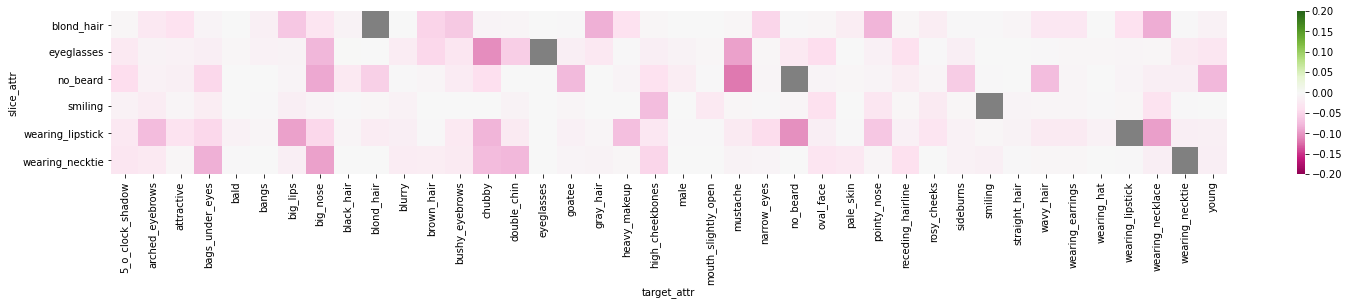

In [32]:
plt.figure(figsize=(25,3))
diff_df = df.groupby(by=["target_attr", "slice_attr"]).auroc_diff.min().to_frame().reset_index()
pivot_df = diff_df.pivot(columns="target_attr", index="slice_attr", values="auroc_diff")
g = sns.heatmap(data=pivot_df, cmap="PiYG", annot=False, vmin=-0.2, vmax=0.2)
g.set_facecolor('gray')

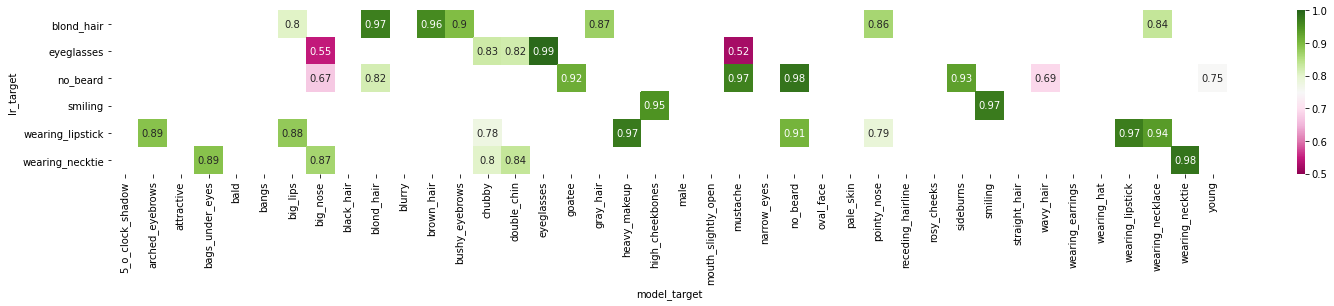

In [23]:
df = terra.out(369).load()
plt.figure(figsize=(25,3))
scribble_pivot_df = df.pivot(columns="model_target", index="lr_target", values="auroc")
g = sns.heatmap(data=scribble_pivot_df, cmap="PiYG", annot=True, vmin=0.5, vmax=1, mask=pivot_df > -0.05)

In [27]:
scribble_pivot_df.values[pivot_df.values<-0.05].mean()

<ipython-input-27-0e8ad78db4df>:1: RuntimeWarning: invalid value encountered in less
  scribble_pivot_df.values[pivot_df.values<-0.05].mean()


0.835031770589321

In [28]:
scribble_pivot_df.values.mean()

0.7833080970744558

In [11]:
degradation = pivot_df.loc["blond_hair"]
transfer = scribble_pivot_df.loc["blond_hair"]

In [13]:
from scipy.stats import spearmanr, pearsonr
corrs = []
for target in ["blond_hair", "eyeglasses", "no_beard", "smiling", "wearing_lipstick", "wearing_necktie"]:
    degradation = pivot_df.loc[target]
    transfer = scribble_pivot_df.loc[target]
    pearson_r, pearson_pvalue = pearsonr(transfer[~degradation.isna()], degradation[~degradation.isna()])
    corrs.append({
        "pearsonr": pearson_r,
        "pearson_pvalue": pearson_pvalue,
        "target": target
    })
pd.DataFrame(corrs)

,pearsonr,pearson_pvalue,target
0,-0.086991,0.598481,blond_hair
1,0.212712,0.193566,eyeglasses
2,-0.395086,0.012802,no_beard
3,-0.594253,0.000066,smiling
4,-0.395573,0.012682,wearing_lipstick
5,-0.038958,0.813848,wearing_necktie


In [84]:
transfer

model_target
5_o_clock_shadow       0.833831
arched_eyebrows        0.833381
attractive             0.867526
bags_under_eyes        0.892318
bald                   0.877469
bangs                  0.791908
big_lips               0.804832
big_nose               0.826426
black_hair             0.913020
blond_hair             0.969404
blurry                 0.845775
brown_hair             0.957550
bushy_eyebrows         0.897479
chubby                 0.857909
double_chin            0.870348
eyeglasses             0.764549
goatee                 0.859910
gray_hair              0.873066
heavy_makeup           0.792070
high_cheekbones        0.743957
male                   0.813016
mouth_slightly_open    0.807481
mustache               0.869831
narrow_eyes            0.664483
no_beard               0.883826
oval_face              0.739242
pale_skin              0.731582
pointy_nose            0.864403
receding_hairline      0.850441
rosy_cheeks            0.837656
sideburns              0.83